In [1]:
import pandas as pd
import mlflow
import joblib
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from commons.load_data import (load_raw_data,
                                  transformed_employee_performance,
                                  feature_engineered_employee_performance)
from commons.eda import (plot_correlation_with_scores,
                         plot_correlation_matrix)
from commons.commons import log_figure
from commons.engineer_features import handle_features
from commons import model_selection

In [2]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("first-group-project")

<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1740318647038, experiment_id='2', last_update_time=1740318647038, lifecycle_stage='active', name='first-group-project', tags={}>

In [3]:
def save_scaler(scaler, name="standard_scaler",
                filename='scaler'):
    """Save and log the StandardScaler to MLflow."""

    with mlflow.start_run(run_name=name):
        joblib.dump(scaler, f"{filename}.pkl")
        mlflow.log_artifact(f"{filename}.pkl")

        mlflow.sklearn.log_model(scaler, name)

In [4]:
def get_data(return_scalers: bool=True):
    data_df = load_raw_data()[:2000]
    data_df = transformed_employee_performance(data_df=data_df)
    new_df, X_scaler, y_scaler = feature_engineered_employee_performance(data_df=data_df,
                                                    return_scaler=True)
    target_fig = plot_correlation_with_scores(new_df)
    features_fig = plot_correlation_matrix(new_df)
    if return_scalers:
        save_scaler(X_scaler, 'x_standard_scaler',
                    'x_scaler')
        save_scaler(y_scaler, 'y_standard_scaler',
                    'y_scaler')
        return new_df, X_scaler, y_scaler, target_fig, features_fig
    else:
        return new_df, None, None, target_fig, features_fig

In [5]:
## Remove False in `get_data` on first run
new_df, X_scaler, y_scaler, target_fig, features_fig = get_data(False)
new_df.head()

Found


,Employee_ID,Age,Years_At_Company,Performance_Score,Monthly_Salary,Work_Hours_Per_Week,Projects_Handled,Overtime_Hours,Sick_Days,Remote_Work_Frequency,...,Gender_Other,Job_Title_Consultant,Job_Title_Developer,Job_Title_Engineer,Job_Title_Manager,Job_Title_Specialist,Job_Title_Technician,Education_Level_High School,Education_Level_Master,Education_Level_PhD
0,1,1.304487,-0.905767,1.459238,6750.0,-1.338554,0.579189,0.857861,-1.129268,-1.420325,...,False,False,False,False,False,True,False,True,False,False
1,2,-1.072960,-1.611744,1.459238,7500.0,-1.225629,0.719795,-0.179665,1.637134,1.394988,...,False,False,True,False,False,False,False,True,False,False
2,3,1.304487,1.212161,0.026506,5850.0,-0.886855,0.227676,-0.986630,-0.898735,-0.012669,...,False,False,False,False,False,True,False,True,False,False
3,4,0.664405,0.859173,-0.689861,4800.0,0.807017,-0.967472,1.549546,1.176067,1.394988,...,False,False,False,False,False,False,False,False,False,False
4,5,-0.432878,-0.552779,-0.689861,4800.0,-0.773930,-0.897169,1.664826,1.406600,1.394988,...,False,False,False,False,False,False,False,False,False,False


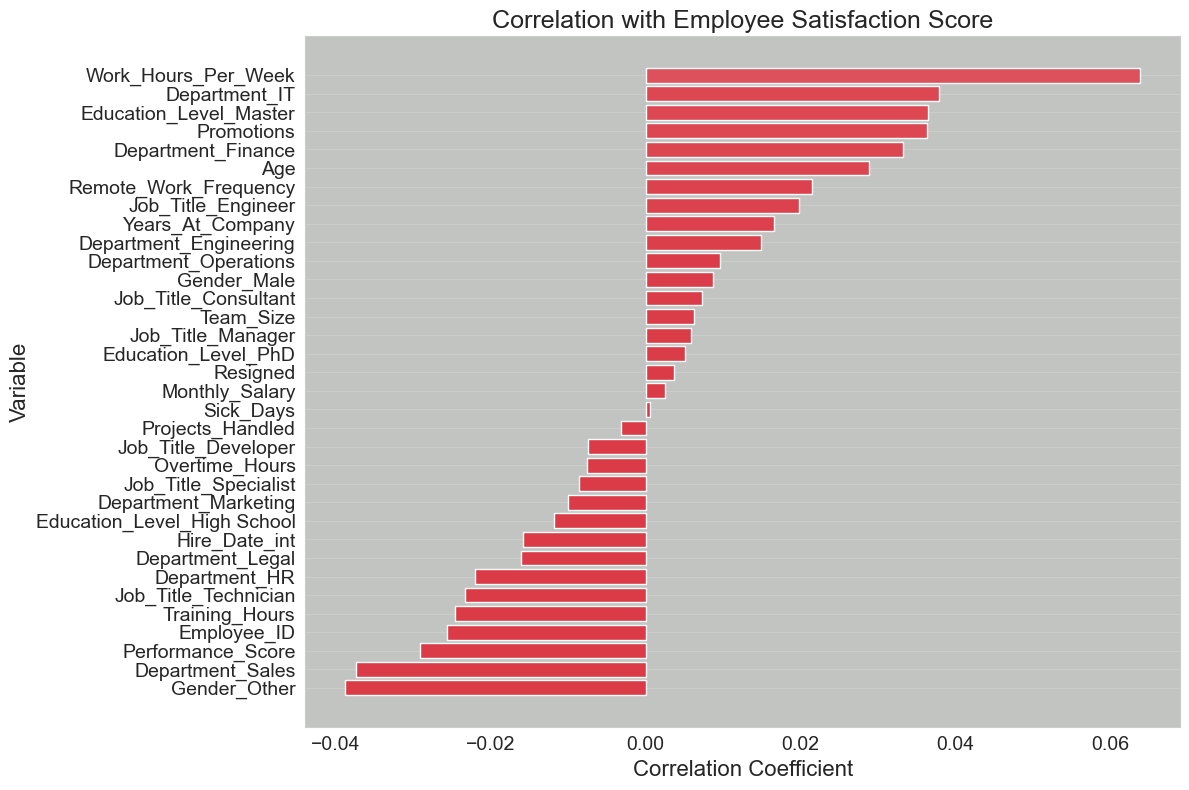

In [6]:
target_fig

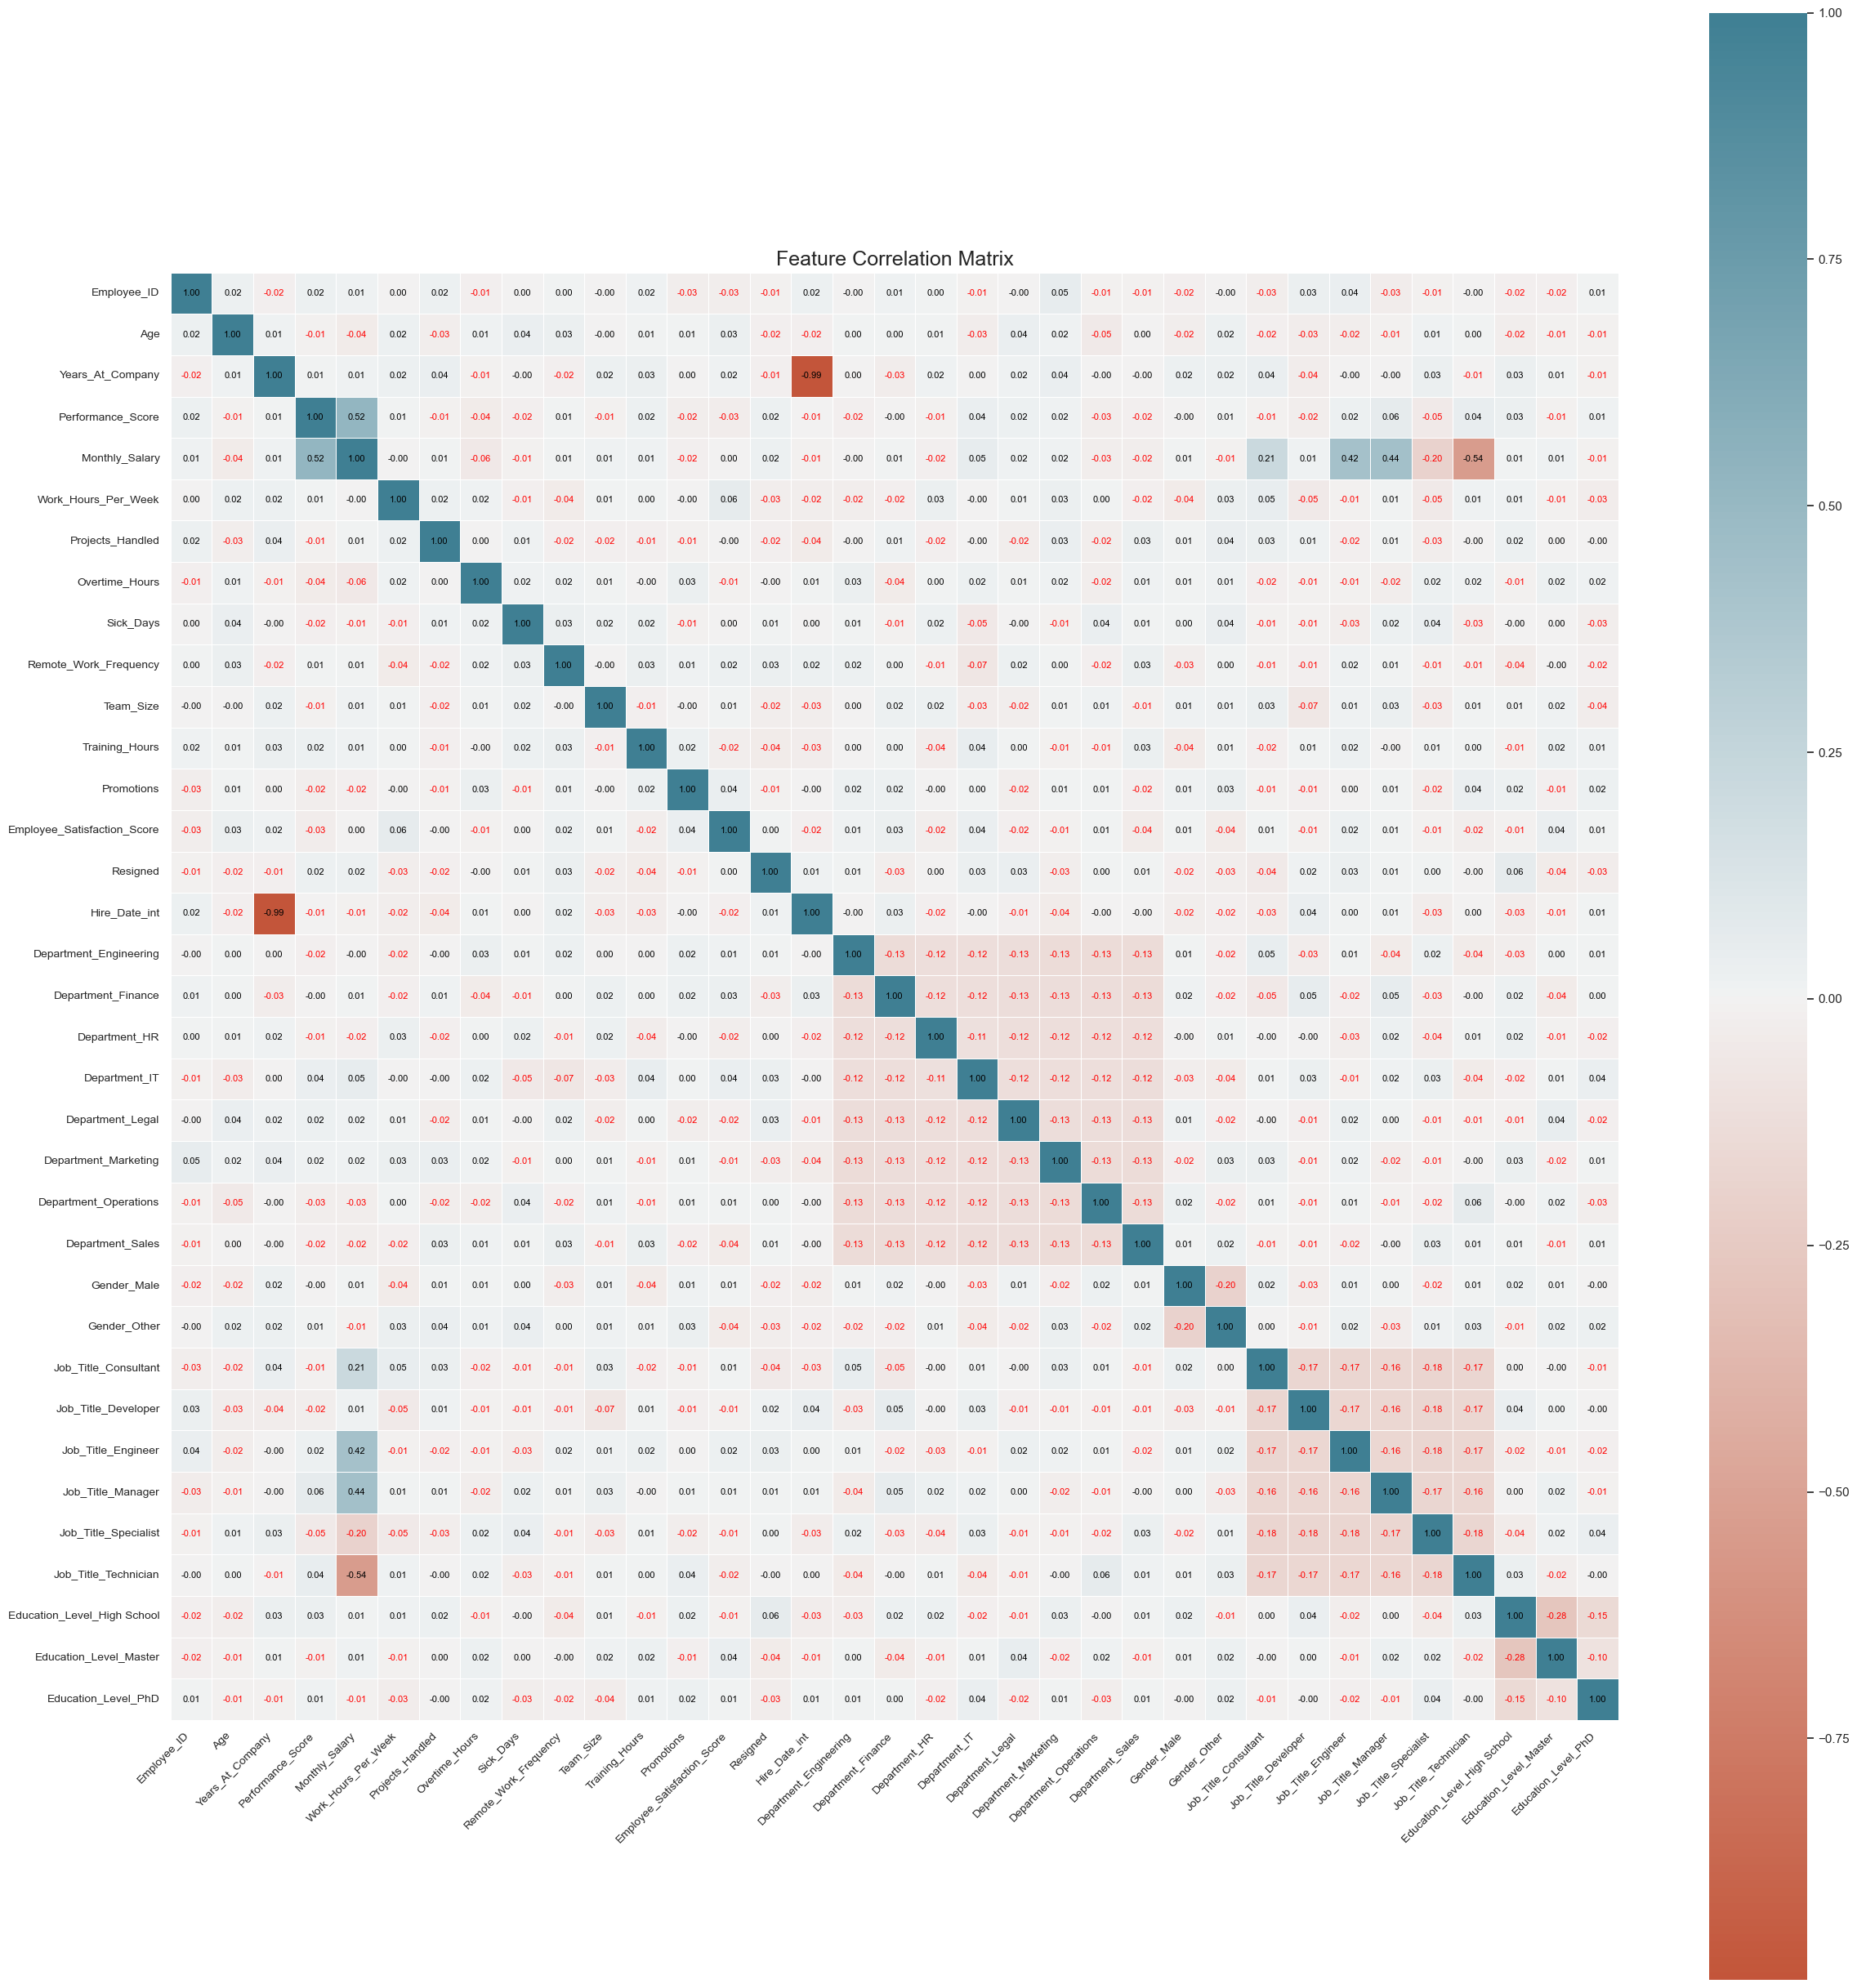

In [7]:
features_fig

In [8]:
log_figure(fig=target_fig,
           artifact_path='target_correlation_plot.png')
log_figure(fig=features_fig,
           artifact_path='features_correlation_plot.png')

In [ ]:
# ## do not run if `get_data` parameter is set as False
# log_figure(fig)
# numeric_columns = get_features()
# newer_df = y_scaler.inverse_transform(
#     new_df['Employee_Satisfaction_Score'].values.reshape(-1, 1)
# )
# pd.DataFrame(newer_df, columns=['Employee_Satisfaction_Score']).head()

,Employee_Satisfaction_Score
0,2.63
1,1.72
2,3.17
3,1.86
4,1.25


In [9]:
def rf_objective(trial, X_train, y_train):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)

    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,  
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf)
    
    score = cross_val_score(model, X_train, y_train, cv=5,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1).mean()
    return score

def gb_objective(trial, X_train, y_train):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)

    model = GradientBoostingRegressor(n_estimators=n_estimators,
                                      learning_rate=learning_rate,
                                      max_depth=max_depth,  
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf)
    
    score = cross_val_score(model, X_train, y_train, cv=5,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1).mean()
    return score

In [ ]:
def train_regression_models(new_df: pd.DataFrame, n_trials: int=200) -> None:
    """
    Train multiple regression models with hyperparameter tuning and log them to MLflow.

    Parameters
    ----------
    new_df : pd.DataFrame
        Feature-engineered dataset.

    Returns
    -------
    None
    """
    new_df = handle_features(new_df)
    X = new_df.drop(columns=["Employee_Satisfaction_Score"])
    y = new_df["Employee_Satisfaction_Score"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    input_example = X_train.iloc[:1]

    objectives = {'rf_regressor': (rf_objective,
                                   RandomForestRegressor),
                  'gboost_regressor': (gb_objective,
                                       GradientBoostingRegressor)}

    if mlflow.active_run():
        mlflow.end_run()
    for name, (objective, model) in objectives.items():
        with mlflow.start_run(nested=True):
            ## Model Selection Step
            study = optuna.create_study(direction='maximize',
                                        study_name=f"{name}_study",
                                        sampler=optuna.samplers.RandomSampler(seed=42))

            study.optimize(lambda trial: objective(trial, X_train, y_train),
                           n_trials=n_trials)
            
            best_params = study.best_params
            mlflow.log_params(best_params)
            opt_hist = optuna.visualization.plot_optimization_history(study)
            opt_parallel = optuna.visualization.plot_parallel_coordinate(study)
            opt_slice = optuna.visualization.plot_slice(study,
                                                        list(best_params.keys()))
            mlflow.log_figure(opt_hist, f"{name}_optimization_history.html")
            mlflow.log_figure(opt_parallel, f"{name}_parallel_coordinate.html")
            mlflow.log_figure(opt_slice, f"{name}_slice_plot.html")

            ## Model Performance Recording
            best_model = model(**best_params).fit(X_train, y_train)
            y_pred = best_model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            feature_importance = model_selection.plot_feature_importance(
                best_model,
                feature_names=X.columns
            )
            residuals_plot = model_selection.plot_residuals(best_model,
                                                            y_test=y_test,
                                                            y_pred=y_pred)
            log_figure(feature_importance, f"{name}_feature_importance.png")
            log_figure(residuals_plot, f"{name}_residuals_plot.png")
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("r2", r2)
            mlflow.sklearn.log_model(best_model, name,
                                     registered_model_name=name,
                                     input_example=input_example)
            print(f"✅ Trained and logged {name} model. MSE: {mse:.4f}, R²: {r2:.4f}")
    mlflow.end_run()

In [11]:
train_regression_models(new_df=new_df)

[I 2025-02-23 23:23:11,725] A new study created in memory with name: rf_regressor_study


🏃 View run capable-cub-988 at: http://localhost:5000/#/experiments/2/runs/96cafaa21bce45019c5e1478c319825f
🧪 View experiment at: http://localhost:5000/#/experiments/2


[I 2025-02-23 23:23:15,572] Trial 0 finished with value: -1.0122220070520478 and parameters: {'n_estimators': 381, 'max_depth': 48, 'min_samples_split': 24, 'min_samples_leaf': 20}. Best is trial 0 with value: -1.0122220070520478.
[I 2025-02-23 23:23:17,648] Trial 1 finished with value: -1.0126136207058756 and parameters: {'n_estimators': 164, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 28}. Best is trial 0 with value: -1.0122220070520478.
[I 2025-02-23 23:23:20,892] Trial 2 finished with value: -1.0089446383456218 and parameters: {'n_estimators': 605, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 32}. Best is trial 2 with value: -1.0089446383456218.
[I 2025-02-23 23:23:25,646] Trial 3 finished with value: -1.0234449092406022 and parameters: {'n_estimators': 834, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 2 with value: -1.0089446383456218.
[I 2025-02-23 23:23:27,151] Trial 4 finished with value: -1.0207798806689679 and

Registered model 'rf_regressor' already exists. Creating a new version of this model...
2025/02/23 23:31:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: rf_regressor, version 6
Created version '6' of model 'rf_regressor'.
[I 2025-02-23 23:31:08,857] A new study created in memory with name: gboost_regressor_study


✅ Trained and logged rf_regressor model. MSE: 1.0066, R²: -0.0212
🏃 View run bustling-bird-89 at: http://localhost:5000/#/experiments/2/runs/c6a481f35b5a4abb9aa5c6c6f2446e4f
🧪 View experiment at: http://localhost:5000/#/experiments/2


[I 2025-02-23 23:31:12,962] Trial 0 finished with value: -1.1751059411519087 and parameters: {'n_estimators': 381, 'max_depth': 48, 'learning_rate': 0.14907884894416698, 'min_samples_split': 20, 'min_samples_leaf': 5}. Best is trial 0 with value: -1.1751059411519087.
[I 2025-02-23 23:31:13,923] Trial 1 finished with value: -1.248301876150752 and parameters: {'n_estimators': 164, 'max_depth': 12, 'learning_rate': 0.1745734676972377, 'min_samples_split': 20, 'min_samples_leaf': 23}. Best is trial 0 with value: -1.1751059411519087.
[I 2025-02-23 23:31:14,209] Trial 2 finished with value: -1.163398323696887 and parameters: {'n_estimators': 30, 'max_depth': 49, 'learning_rate': 0.16816410175208013, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 2 with value: -1.163398323696887.
[I 2025-02-23 23:31:15,827] Trial 3 finished with value: -1.1624962544398976 and parameters: {'n_estimators': 191, 'max_depth': 22, 'learning_rate': 0.10970372201012518, 'min_samples_split': 15, 'min_s

Registered model 'gboost_regressor' already exists. Creating a new version of this model...
2025/02/24 00:47:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: gboost_regressor, version 4


✅ Trained and logged gboost_regressor model. MSE: 1.0006, R²: -0.0150
🏃 View run resilient-pig-302 at: http://localhost:5000/#/experiments/2/runs/e2dfb16211184fdea5e05c4342bc289d
🧪 View experiment at: http://localhost:5000/#/experiments/2


Created version '4' of model 'gboost_regressor'.
